<a href="https://colab.research.google.com/github/nahumsa/OpenFermionQiskit/blob/main/notebooks/Fermi-Hubbard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip install openfermion
! pip install qiskit
clear_output()

In [2]:
! git clone https://github.com/nahumsa/OpenFermionQiskit.git
% cd OpenFermionQiskit
clear_output()

# Fermi-Hubbard model

Let's show the integration using a Fermi-Hubbard example.

In [3]:
from openfermion.utils import HubbardSquareLattice

# HubbardSquareLattice parameters
x_n = 2 # Number of sites in x
y_n = 1 # Number of sites in y
n_dofs = 1 # Degree of freedom
periodic = False 
spinless = False 

lattice = HubbardSquareLattice(x_n, y_n, n_dofs=n_dofs, 
                               periodic=periodic, spinless=spinless)

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for neighbors in lattice.neighbors_iter():
  G.add_edge(*neighbors)

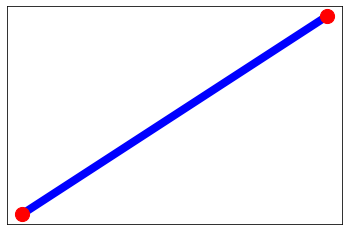

In [5]:
pos = nx.spring_layout(G)
options = {"node_size": 200, "alpha": 1.}
nx.draw_networkx_nodes(G, pos, nodelist=list(G.nodes), 
                       node_color="r", **options)
nx.draw_networkx_edges(G,pos,edgelist=list(G.edges),
                       width=8, edge_color="b")
plt.show()

In [6]:
from openfermion.hamiltonians import FermiHubbardModel
from openfermion.utils import SpinPairs

t = 1.
tunneling = [('neighbor', (0, 0), t)] 
U = 3.
interaction = [('onsite', (0, 0), U, SpinPairs.DIFF)] 

potential = [(0, U/2.)] # Must be U/2 for half-filling
mag_field = 0. 
particle_hole_sym = False

hubbard = FermiHubbardModel(lattice , tunneling_parameters=tunneling, 
                            interaction_parameters=interaction, 
                            potential_parameters=potential, magnetic_field=mag_field, 
                            particle_hole_symmetry=particle_hole_sym)

hamiltonian = hubbard.hamiltonian()
print('Hamiltonian:\n', hamiltonian)

Hamiltonian:
 -1.5 [0^ 0] +
3.0 [0^ 0 1^ 1] +
-1.0 [0^ 2] +
-1.5 [1^ 1] +
-1.0 [1^ 3] +
-1.0 [2^ 0] +
-1.5 [2^ 2] +
3.0 [2^ 2 3^ 3] +
-1.0 [3^ 1] +
-1.5 [3^ 3]


In [11]:
from IPython.display import display, Math, Latex
from openfermionqiskit.utils import latex_string_f_operator
  
latex_fop = latex_string_f_operator(hamiltonian)
# print(latex_fop)
display(Math(latex_fop))

<IPython.core.display.Math object>

In [12]:
from openfermion.utils import get_ground_state
from openfermion.transforms import get_sparse_operator

# Get scipy.sparse.csc representation.
sparse_operator = get_sparse_operator(hamiltonian)
energy = get_ground_state(sparse_operator)[0]
print(f'Energy of the model is {energy}.')

Energy of the model is -3.9999999999999964.


# Converting to qiskit and running on VQE

In [13]:
from openfermionqiskit.converters import QiskitConverter

h_Op = QiskitConverter(hamiltonian=hamiltonian, map_type='jw')
print(h_Op.pauli_op)

SummedOp([
  (-0.5+0j) * YZYI,
  (-0.5+0j) * XZXI,
  (-0.5+0j) * IYZY,
  (-0.5+0j) * IXZX,
  (0.75+0j) * ZZII,
  (0.75+0j) * IIZZ,
  (-1.5+0j) * IIII
])


In [14]:
from qiskit.aqua.algorithms import VQE
from qiskit.circuit.library import TwoLocal
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np

In [15]:
def create_var_form(qubits, n_cx, reps, one_qubit_gates=['ry','rz']):
  return TwoLocal(qubits, one_qubit_gates, ['cx']*n_cx, reps=reps)  

In [16]:
var_form = create_var_form(qubits=h_Op.n_qubits, n_cx=5, reps=3) 
optimizer = COBYLA()
vqe = VQE(h_Op.pauli_op, var_form, optimizer)

In [17]:
from qiskit import Aer
from qiskit.aqua import QuantumInstance
import numpy as np

backend = Aer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend=backend, 
                                   shots=5000,)
vqe_result = np.real(vqe.run(backend)['eigenvalue'])

In [18]:
print(f"Error: {np.round(np.abs((vqe_result - energy)/energy)*100, 2)}%")

Error: 0.01%
